# Word Count with MapReduce and Hadoop Streaming

Note: Execute the cells in order to avoid execution errors. This ensures that all necessary files are created and placed correctly throughout the process.

## Creation of the folder and the test file

In [3]:
# Create the folder
! mkdir -p /media/notebooks/word-count-example

In [4]:
# Move to the folder
import os
os.chdir("/media/notebooks/word-count-example")
! pwd

/media/notebooks/word-count-example


In [5]:
# Create the file with the text
! echo "this file is a word counter test" >> test.txt
! echo "words will be counted according to their number of occurrences in this file" >> test.txt

In [7]:
# Show the content of the file
!cat test.txt

this file is a word counter test
words will be counted according to their number of occurrences in this file


## Creation of Map and Reduce Processes

The first line, `%%writefile mapper.py`, will write the file to the system, while the second line, in the form of a comment, specifies the interpreter that should be used. In this case, since it is written in Python, it is: `#!/usr/bin/env python3`.

In [9]:
%%writefile mapper.py
#!/usr/bin/env python3

import sys

# Standard Input STDIN
for line in sys.stdin:
  line = line.strip()
  # Divide each line into words
  words = line.split()
  # Each word is written together with a 1 and this is the reducer input
  for word in words:
    print ('%s\t%s' % (word, 1))

Overwriting mapper.py


In [14]:
%%writefile reducer.py
#!/usr/bin/env python3

from collections import defaultdict
import sys

# We use a dictionary for words with an integer as a value
word_counter = defaultdict(int)

# For each line we count the total number of appearances
for line in sys.stdin:
    word, number = line.strip().split('\t')
    word_counter[word] += int(number)

# We write for each word the total number of occurrences
for word in sorted(word_counter.keys()):
    print ('%s\t%s' % (word_counter[word], word))

Overwriting reducer.py


In [15]:
# See the files 
! ls /media/notebooks/word-count-example

mapper.py  reducer.py  test.txt  word-count-output


## Running MapReduce Locally

In [16]:
# Run map-reduce from the terminal
! cat /media/notebooks/word-count-example/test.txt \
| python3 mapper.py | sort | python3 reducer.py > word-count-output

In [17]:
# See the output
! cat word-count-output

1	a
1	according
1	be
1	counted
1	counter
2	file
1	in
1	is
1	number
1	occurrences
1	of
1	test
1	their
2	this
1	to
1	will
1	word
1	words


## Running MapReduce in HDFS

### Create the Scripts and Test Locally

In [18]:
! pwd

/media/notebooks/word-count-example


In [19]:
# Create the folder
! mkdir -p /media/notebooks/word-count-example-2

In [20]:
os.chdir("/media/notebooks/word-count-example-2")
! pwd

/media/notebooks/word-count-example-2


In [22]:
! cp /media/notebooks/word-count-example/mapper.py /media/notebooks/word-count-example/reducer.py /media/notebooks/word-count-example-2/

In [23]:
! ls /media/notebooks/word-count-example-2

100-0.txt  mapper.py  plays-shakespeare.txt  reducer.py


Now we are going to download a test file containing all Shakespeare's works from Project Gutenberg, an initiative that offered a collection of free books in order to collaborate with society to improve public literacy.

We will also remove some problematic characters and other punctuation marks. 

In [21]:
# Download all Shakespeare's plays and clean up the document to save it in plays-shakespeare.txt
! wget http://www.gutenberg.org/files/100/100-0.txt 
! cat 100-0.txt | sed -e 's/^\xEF\xBB\xBF//' | tr -d '.,;?!(&_*-' > plays-shakespeare.txt

--2024-11-09 15:24:54--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/100-0.txt [following]
--2024-11-09 15:24:55--  https://www.gutenberg.org/files/100/100-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5618733 (5.4M) [text/plain]
Saving to: ‘100-0.txt’

100-0.txt           100%[===================>]   5.36M  1.04MB/s    in 5.5s    

2024-11-09 15:25:01 (991 KB/s) - ‘100-0.txt’ saved [5618733/5618733]



In [25]:
# Run our map-reduce
! cat plays-shakespeare.txt | python3 mapper.py \
| sort | python3 reducer.py > shakespeare-word-count

# Show some examples of output
! head -8000 shakespeare-word-count | tail -10

1	Rebelled
3	Rebellion
6	Rebellious
1	Rebels
2	Rebuke
1	Rebukeable
1	Recall
1	Recantation
1	Recanting
17	Receive


### Run in Hadoop Cluster

Once we have verified the correct operation of the MapReduce code, we can run it on our Hadoop cluster. By doing this, we will be using the full power of our cluster.

The first thing to do is to upload the file we want to process to HDFS. Before, we will create a folder containing this file and the output.

In [26]:
# Create a new folder for the counter example in HDFS
! hdfs dfs -mkdir /word-count-example

# Upload the file plays-shakespeare to HDFS
! hdfs dfs -put /media/notebooks/word-count-example-2/plays-shakespeare.txt /word-count-example

# Check that they have been uploaded correctly
! hdfs dfs -ls /word-count-example

Found 1 items
-rw-r--r--   3 root supergroup    5386993 2024-11-09 15:33 /word-count-example/plays-shakespeare.txt


In [28]:
# Execute the hadoop command to apply map-reduce
! hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-files mapper.py,reducer.py \
-mapper mapper.py \
-reducer reducer.py \
-input /word-count-example/plays-shakespeare.txt \
-output /word-count-example/output

packageJobJar: [/tmp/hadoop-unjar3045023563548009164/] [] /tmp/streamjob4428763553398023230.jar tmpDir=null
2024-11-09 15:36:57,328 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2024-11-09 15:36:57,402 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.18.0.3:8032
2024-11-09 15:36:57,534 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1731146251920_0002
2024-11-09 15:36:57,788 INFO mapred.FileInputFormat: Total input files to process : 1
2024-11-09 15:36:57,854 INFO mapreduce.JobSubmitter: number of splits:2
2024-11-09 15:36:57,928 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1731146251920_0002
2024-11-09 15:36:57,928 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-11-09 15:36:58,022 INFO conf.Configuration: resource-types.xml not found
2024-11-09 15:36:58,022 INFO resource.ResourceUtils

In [29]:
# Check the output files
! hdfs dfs -ls /word-count-example/output

Found 2 items
-rw-r--r--   3 root supergroup          0 2024-11-09 15:37 /word-count-example/output/_SUCCESS
-rw-r--r--   3 root supergroup     466108 2024-11-09 15:37 /word-count-example/output/part-00000


In [31]:
# Show the contents of the file
! hdfs dfs -cat /word-count-example/output/part-00000  | head -8000 | tail -10

cat: Unable to write to output stream.1	Rebelled
3	Rebellion
6	Rebellious
1	Rebels
2	Rebuke
1	Rebukeable
1	Recall
1	Recantation
1	Recanting
17	Receive



If we enter the Job History (http://localhost:19888/jobhistory) we can see the history of MapReduce jobs and access any of them. Example:

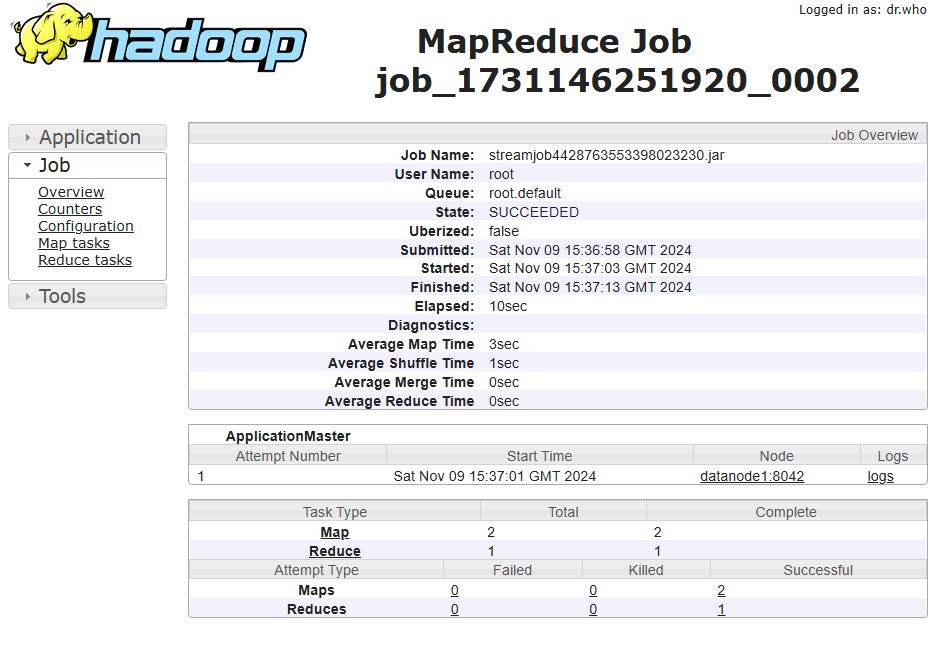